# Задачи, цели работы


## Цель работы


Цель данной лабораторной работы заключается в изучении и реализации методов высокого порядка для решения задач оптимизации, таких как Gauss-Newton, Dog Leg, BFGS.

## Задачи для достижения указанной цели

1. Реализация методов Gauss-Newton и Powell Dog Leg для решения нелинейной регрессии. Сравнение их эффективности с методами, реализованными в предыдущих работах.
2. Реализация метода BFGS для минимизации различных функций. Исследование его сходимости и сравнение с другими реализованными методами.
3. Реализация и исследование метода L-BFGS, аналогично методу BFGS.
4. Подготовка отчёта, содержащего описание реализованных методов, тесты, таблицы и графики для демонстрации результатов.

# Ход работы

## Подготовка среды, определение полезных функций

### В предыдущих сериях:

In [2]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import profiler
import descent
import regression
import visualization
import dataset

In [3]:
plt.rcParams["figure.figsize"] = (10, 10)
np.set_printoptions(precision=2, suppress=False)

### Dataset

In [4]:
data = dataset.get_data()
data_weather = dataset.get_data_weather()

### Learning rate scheduling + Adam

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.06261281448365322
Всего точек: 901
Минимум в  [0.7764009055909922 5.661709134818655]
Значение функции в точке минимума:  2310.414571927687


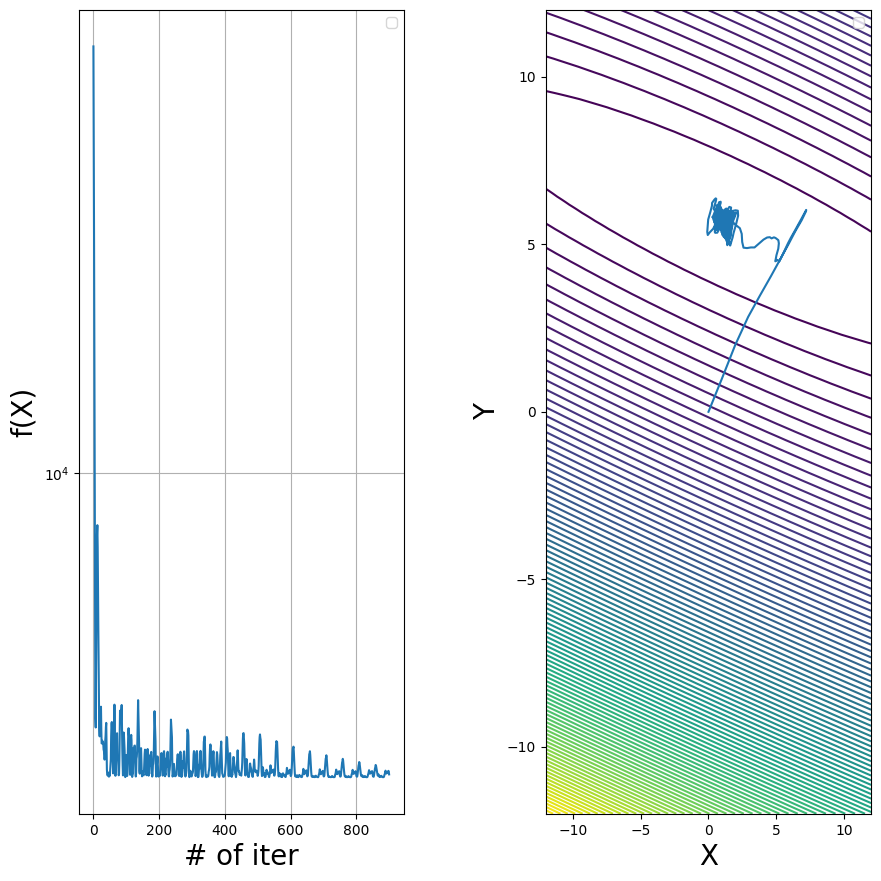

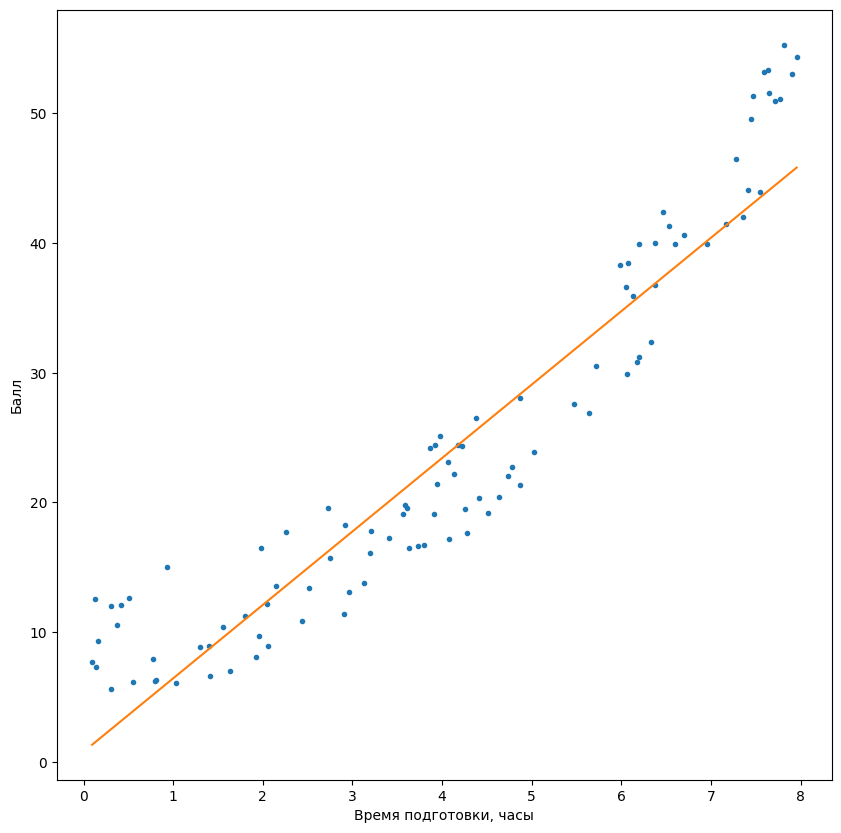

In [5]:
from funcs import squared

f, f_chunk = dataset.get_linear_loss_func(*data)
visualization.linear_demo_2args(
    descent.adam_minibatch_descent(
        f=squared(f_chunk),
        df=descent.numeric_gradient,
        x0=np.array([0.0, 0.0]),
        decay=descent.exp_decay(1.0, 0.1),
        n_epochs=1000,
        batch_size=2,
        tol=0.09,
    ),
    f,
    *data
)

### Non-Linear regression function

Рассмотрим датасет средней температуры на протяжении года (от Яндекса):

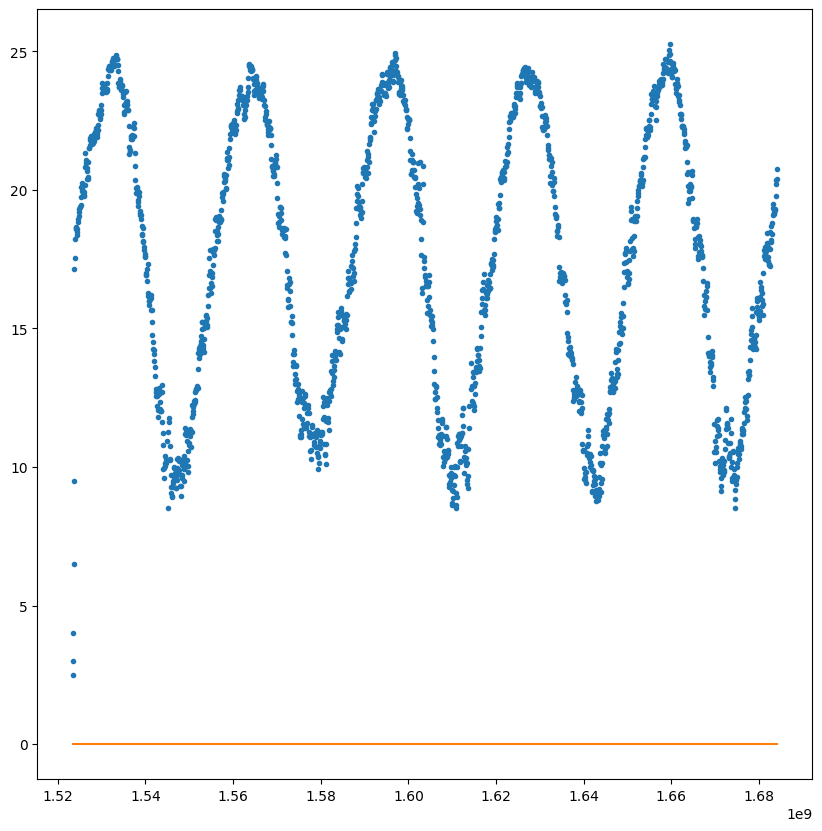

In [6]:
visualization.visualize_regression([0.0], *data_weather)

Как видим, данные вполне периодичны. Попробуем их описать синусом:

Определим модель как
$$M(x, W) = W_1 + W_2 \cdot x + W_3 \cdot x^2 + W_4 \cdot x^3 + W_5 \cdot \sin (x \cdot W_6 + W_7)$$
Тогда Loss-функция будет выглядеть как
$$
f(W) = \sum_{i\in{DATA_x}} (DATA_{yi} - M(i))^2
$$

In [7]:
from funcs import squared

f, f_chunk = dataset.get_nonlinear_loss_func(*data_weather)
points = descent.adam_minibatch_descent(
    f=squared(f_chunk),
    df=descent.numeric_gradient,
    x0=np.array([0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]),
    decay=descent.exp_decay(0.000000001, 0.1),
    n_epochs=10,
    batch_size=2,
    tol=0.09,
)

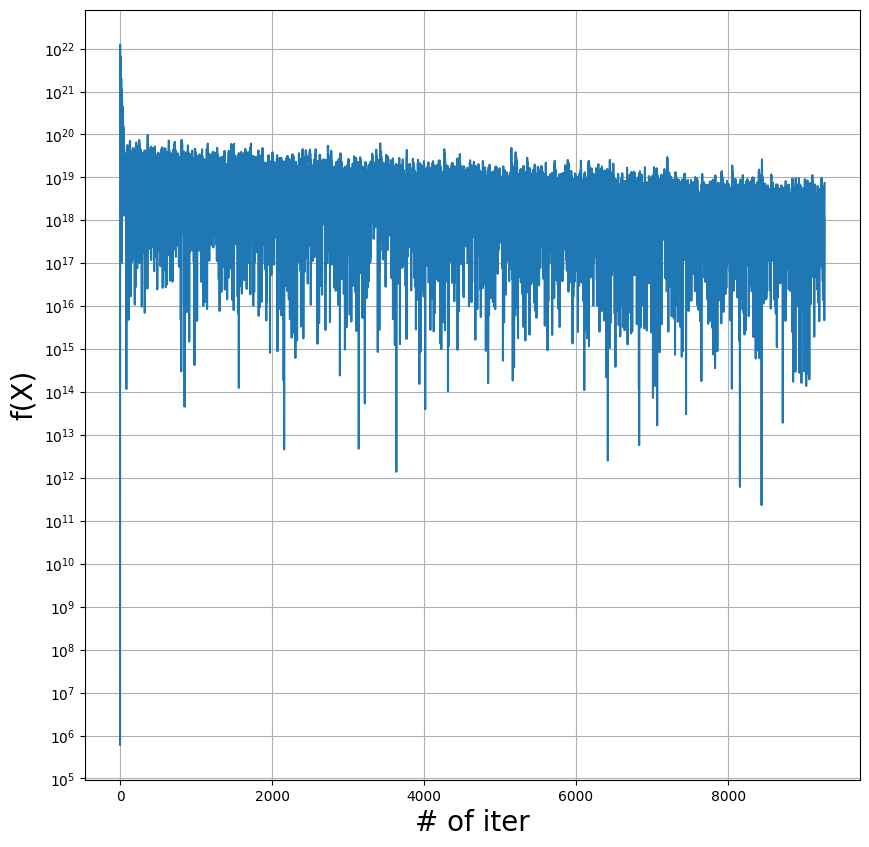

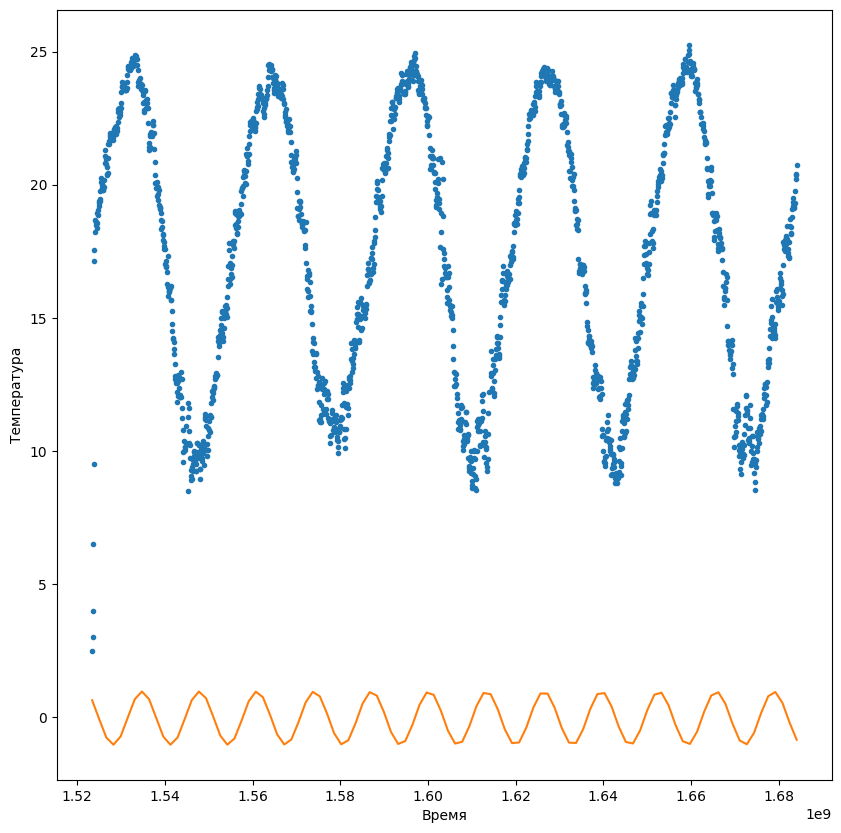

In [8]:
visualization.visualize_descent(points, f)
visualization.visualize_regression(
    points[-1], *data_weather, "Время", "Температура", regression.sine_model
)

Нетрудно заметить, что у ранее изученных методов (на примере Adam) нет шансов зафитить такую сложную модель.

### Rosenbrock function

Определим её следующим образом:
$$
f(x, y) = (1 - x)^2 + 100(y - x^2)^2
$$
Это нелинейная функция, будем использовать её минимизировать для демонстрации работы некоторых методов в будущем.

### Gauss-Newton

Метод Гаусса-Ньютона является итерационным методом решения задачи нелинейной оптимизации. В частности, метод используется для нахождения минимальных значений в наименьших квадратах и полезен в случаях, когда экспериментальным данным можно приблизить нелинейную функцию.

Для описания метода предполагается, что у нас есть набор данных $(x_i, y_i)$ для $i=1,2,...,n$ и мы хотим минимизировать невязку между данными и моделью $\mathbf{F}(\mathbf{p},x_i)$, где $\mathbf{p}=[p_1,p_2,...,p_m]^T$ вектор параметров модели. Оптимизируемая функция:

$$
S(\mathbf{p}) = \sum_{i=1}^{n} r_i(\mathbf{p})^2 = \sum_{i=1}^{n} (y_i - \mathbf{F}(\mathbf{p},x_i))^2
$$

где $r_i(\mathbf{p})$ - вектор невязки.

Алгоритм следующий:

1. Выбрать начальное приближение вектора параметров модели $\mathbf{p}_{0}$.

2. На каждой итерации определить матрицу Якоби $J(\mathbf{p}_{k})$:

$$
J(\mathbf{p}_{k}) = \begin{bmatrix} \frac{\partial r_1(\mathbf{p})}{\partial p_1} & \cdots & \frac{\partial r_1(\mathbf{p})}{\partial p_m} \\ \vdots & \ddots & \vdots\\ \frac{\partial r_n(\mathbf{p})}{\partial p_1} & \cdots & \frac{\partial r_n(\mathbf{p})}{\partial p_m} \end{bmatrix}
$$

3. Решить линейную систему для коррекции $\Delta \mathbf{p}_{k}$:

$$
(J^{T}(\mathbf{p}_{k}) J(\mathbf{p}_{k})) \Delta \mathbf{p}_{k} = - J^{T}(\mathbf{p}_{k}) \mathbf{r}(\mathbf{p}_{k})
$$

4. Обновить значение вектора параметров, используя $\Delta \mathbf{p}_{k}$:

$$
\mathbf{p}_{k+1} = \mathbf{p}_{k} + \Delta \mathbf{p}_{k}
$$

5. Проверить условие сходимости (например, по норме $\Delta \mathbf{p}_k$):

$$
\|\Delta \mathbf{p}_{k}\| < \text{tol}.
$$

Если условие выполняется, остановить итерации и вернуть полученный результат $\mathbf{p}_{k+1}$. В противном случае, повторить процесс, начиная со шага 2.

Важно отметить, что скорость сходимости и качество найденного решения сильно зависит от начального приближения $\mathbf{p}_{0}$.

#### Демонстрация на линейной регрессии

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Всего точек: 5
Минимум в  [1.22 5.69]
Значение функции в точке минимума:  2278.9030971957636


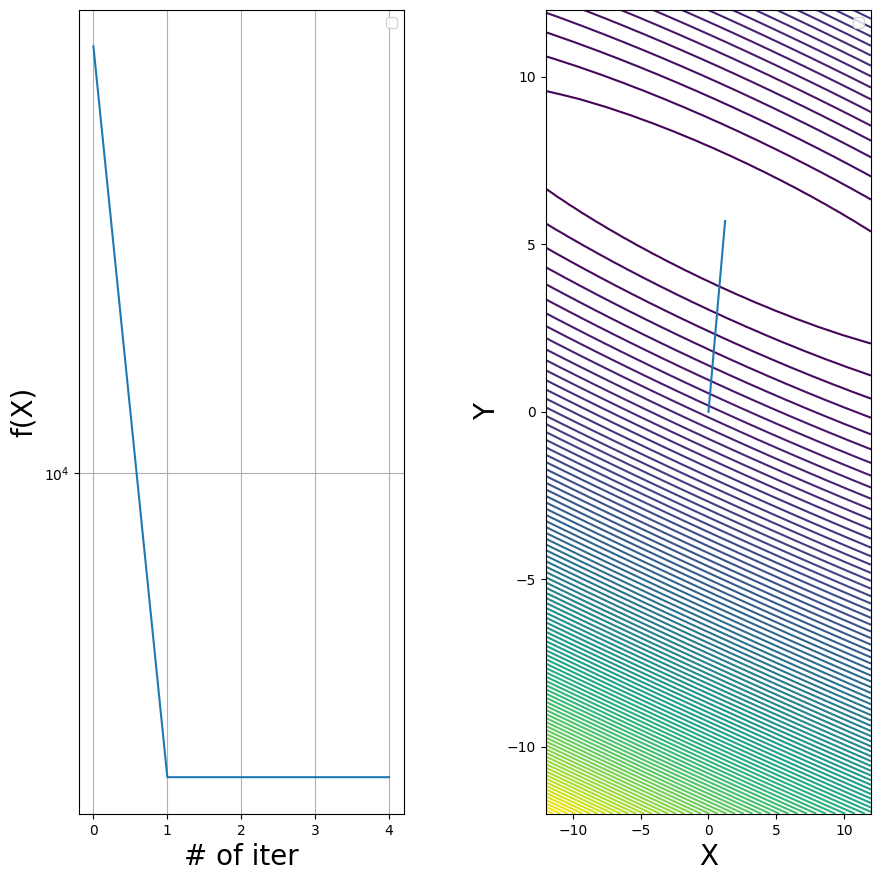

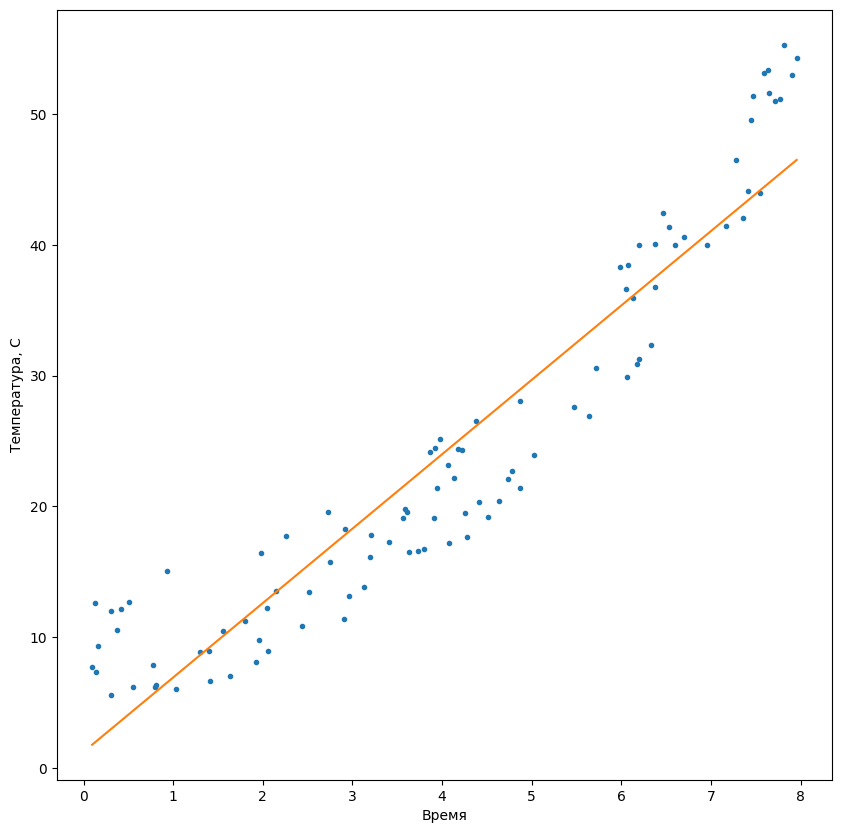

In [9]:
f, f_chunk = dataset.get_linear_loss_func(*data)
visualization.linear_demo_2args(
    descent.gauss_newton_descent(
        x0=np.array([0.0, 0.0]), rsl=f_chunk, grad=descent.numeric_gradient
    ),
    f,
    *data,
    "Время",
    "Температура, C"
)

#### Демонстрация на нелинейной регрессии

[array([1.5e+01, 0.0e+00, 0.0e+00, 0.0e+00, 8.0e+00, 1.0e-07, 2.0e+00]), array([1.50e+01, 0.00e+00, 6.73e-74, 1.76e-55, 8.00e+00, 1.00e-07,
       2.00e+00])]


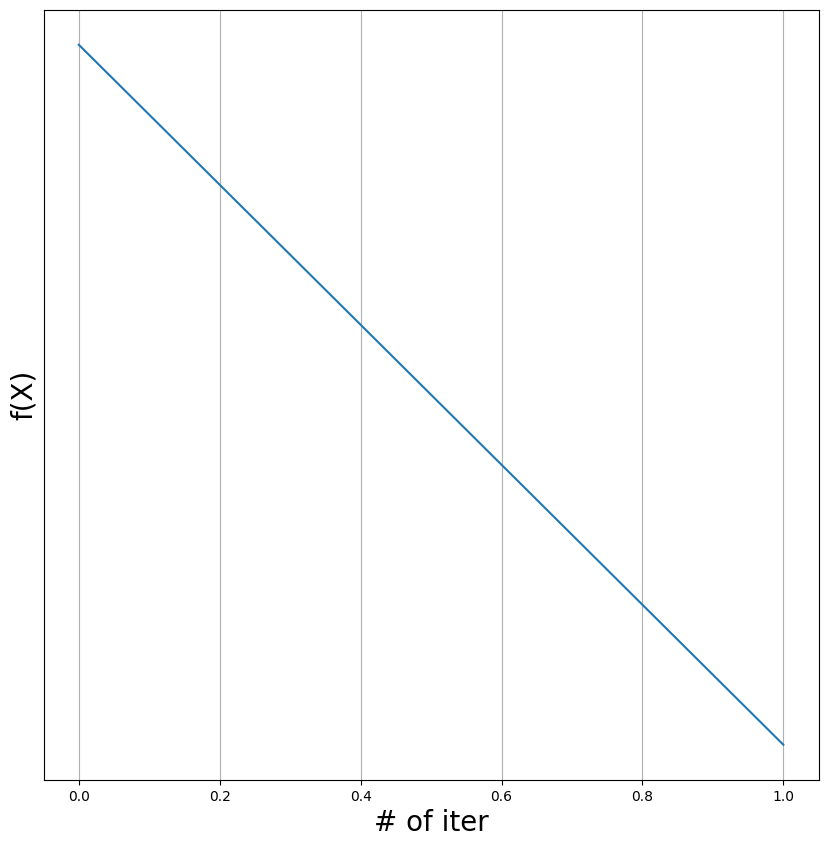

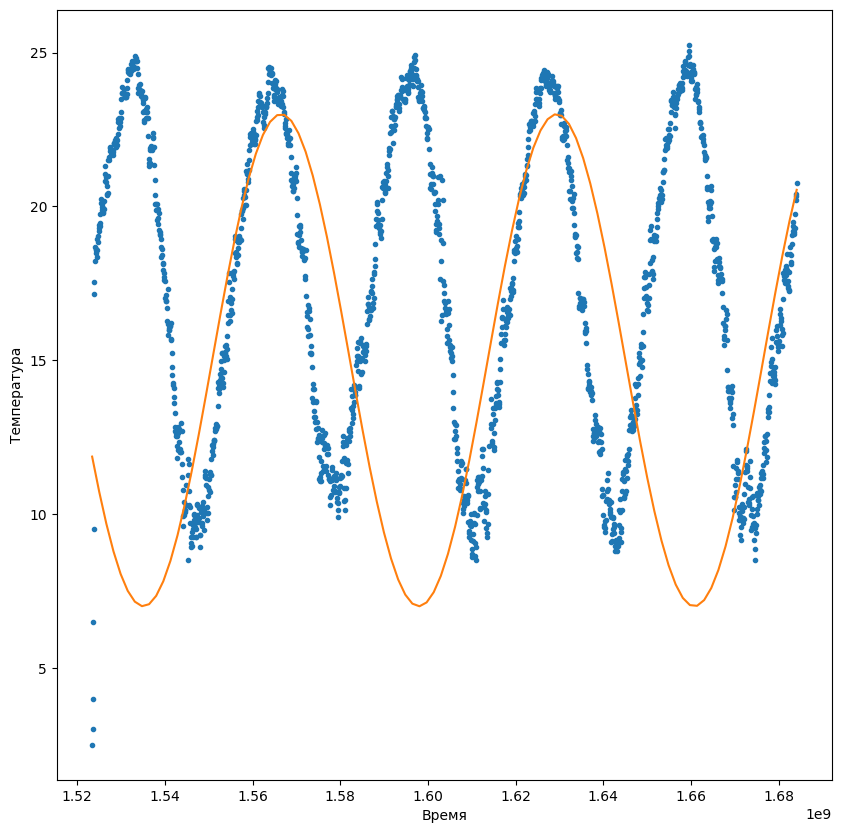

In [10]:
reload(descent)
reload(dataset)
reload(regression)
f, f_chunk = dataset.get_nonlinear_loss_func(*data_weather)
points = descent.gauss_newton_descent(
    x0=np.array([15.0, 0.0, 0.0, 0.0, 8, 1e-7, 2]),
    rsl=f_chunk,
    grad=descent.numeric_gradient,
)
print(points)
visualization.visualize_descent(points, f)
visualization.visualize_regression(
    points[-1], *data_weather, "Время", "Температура", regression.sine_model
)

### Powell Dog Leg

Алгоритм Пауэлла — это итеративный алгоритм оптимизации, который решает задачи неограниченной оптимизации.

На каждой итерации алгоритм вычисляет шаг Гаусса-Ньютона и шаг наискорейшего спуска. Затем он решает, какой шаг предпринять, исходя из размера шага и текущего радиуса траст региона. Радиус траст региона корректируется на основе отношения фактического уменьшения значения функции к прогнозируемому уменьшению.

В алгоритме используются следующие формулы:

- Шаг Гаусса-Ньютона: $dp_{gn} = (J^T J)^{-1} J^T r$

- Самый крутой шаг спуска: $dp_{sd} = -\frac{g^T g}{g^T B g} g$, где $g = J^T r$

- Направление шага: $dp = \begin{cases} dp_{gn} & \text{if } \|dp_{gn}\| \leq \delta \\ dp_{sd} & \text{if } \|dp_{sd}\| \geq \delta \\ \alpha dp_{gn} + (1-\alpha) dp_{sd} & \text{иначе} \end{cases}$

- Настройка радиуса области доверия: если $\rho > 0,75$, увеличить $\delta$, если $\rho < 0,25$, уменьшить $\delta$. $\rho$ определяется как $\frac{\|r\|-\|r(p-dp)\|}{\|dp\|}$.

[array([1.6e+01, 0.0e+00, 0.0e+00, 0.0e+00, 8.5e+00, 1.0e-07, 2.9e+00]), array([1.60e+01, 0.00e+00, 2.92e-74, 7.64e-56, 8.50e+00, 1.00e-07,
       2.90e+00])]


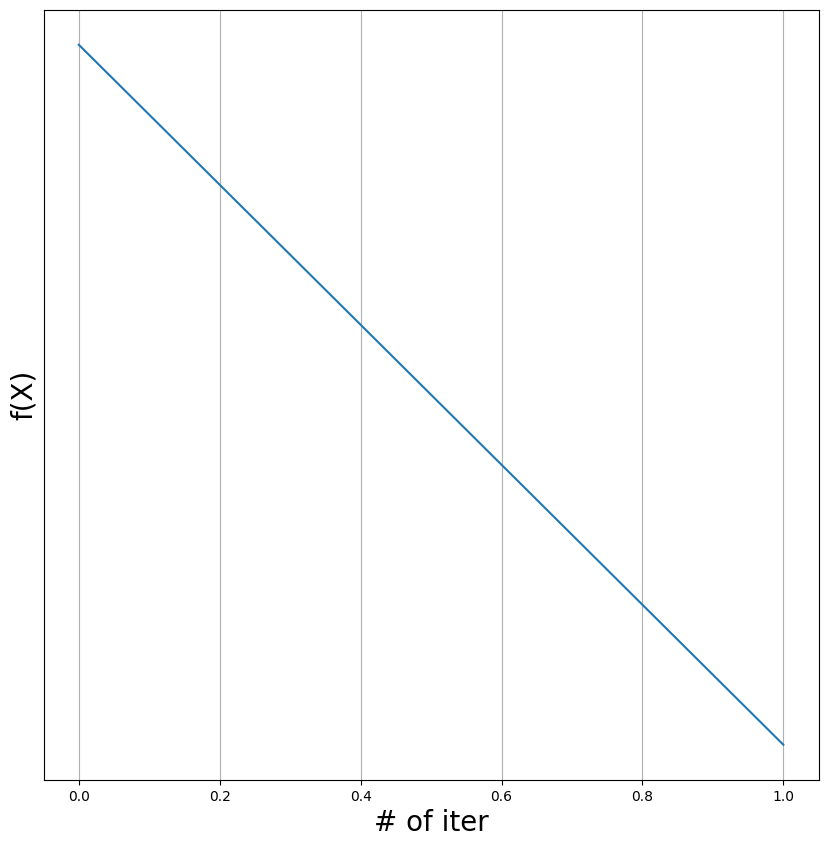

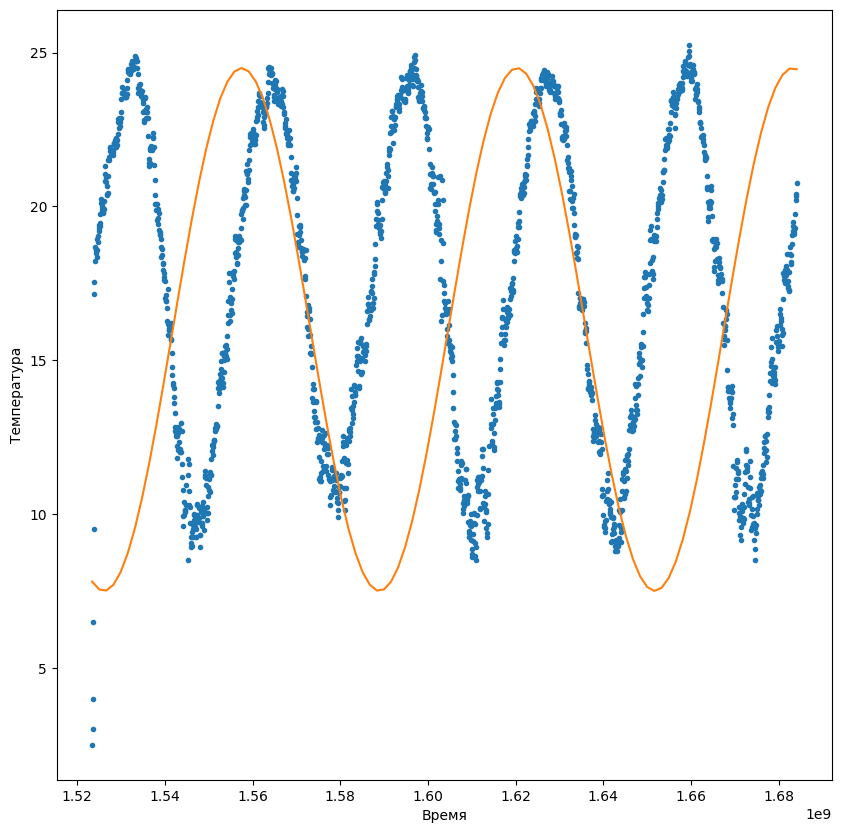

In [11]:
f, f_chunk = dataset.get_nonlinear_loss_func(*data_weather)
points = descent.powell_dog_leg(
    x0=np.array([16.0, 0.0, 0.0, 0.0, 8.5, 1e-7, 2.9]),
    rsl=f_chunk,
    grad=descent.numeric_gradient,
)
print(points)
visualization.visualize_descent(points, f)
visualization.visualize_regression(
    points[-1], *data_weather, "Время", "Температура", regression.sine_model
)

### Выводы

Методы Gauss-Newton и Powell's Dog Leg являются специализированными методами оптимизации, которые обычно используются для решения задач нелинейной регрессии. Они основаны на идее использования линеаризации модели для упрощения процесса оптимизации.

Метод Gauss-Newton

Метод Gauss-Newton - это итерационный метод, который использует градиент функции потерь и приближение к матрице Гессе на каждом шаге для обновления параметров модели. Он обычно работает хорошо для задач нелинейной регрессии, где функция потерь достаточно хорошо приближается квадратичной функцией вблизи минимума.

*Преимущества:*
- Эффективен для задач, где функция потерь хорошо приближается квадратичной функцией.
- Прост в реализации.

*Недостатки:*
- Может быть неэффективен для задач с неквадратичной функцией потерь.
- Часто требует больше итераций для сходимости по сравнению с другими методами.

Powell's Dog Leg

Powell's Dog Leg - это более сложный метод, который пытается сделать компромисс между шагами по направлению градиента и шагами по направлению Гаусса-Ньютона. Он обычно работает лучше, когда функция потерь не является идеально квадратичной.

*Преимущества:*
- Может справиться с функциями потерь, которые не являются идеально квадратичными.
- Часто сходится быстрее, чем Gauss-Newton.

*Недостатки:*
- Более сложен в реализации.
- Может быть нестабильным при плохих начальных приближениях.

В целом, оба этих метода имеют преимущества перед классическим градиентным спуском при решении задач нелинейной регрессии, потому что они используют больше информации о функции потерь. Они обычно сходятся быстрее и могут лучше справиться с неквадратичными функциями потерь. Однако они также могут быть более сложными в реализации и могут требовать более тонкой настройки параметров для достижения хороших результатов.


## Задание 2. Исследование метода BFGS


Алгоритм Бройдена — Флетчера — Гольдфарба — Шанно (BFGS) --- ещё один из квазиньютоновских методов оптимизации. Как и все методы этой категории, решается задача оптимизации функции $f$ с помощью её разложения в полином второй степени:

$f(x_k + p_k) \approx f(x_k) + \langle \nabla f(x_k), p_k \rangle + \frac{1}{2}\langle p_k, B_k p_k \rangle$

Где $B_k = \nabla^{2} f(x_k)$ --- гессиан функции в точке $x_k$. Поскольку его вычисление обычно очень дорогое, BFGS вычисляет его приближенное решение, после чего получается минимум квадратичной задачи:

$p_k = -B_k^{-1}\nabla f(x_k)$

Далее ищется точка, для которой выполняются условия Вольфе и алгоритм "шагает" в этом направлении. Также, для удобства, обратный приближенный гессиан обозначается далее $-B_k^{-1} = H_k$

В качестве начального приближения гессиана обычно выбирается невырожденная, хорошо обусловленная матрица. Хорошо подходит единичная. Пересчёт осуществляется по формулам:
$p_k = -H_k\nabla f(x_k)$
$s_k = x_{k + 1} - x_k = \alpha \cdot p_k$
$y_k = \nabla f(x_{k + 1}) - \nabla f(x_k)$


$H_{k + 1} = (E - \rho_k y_k^{T} s_k) H_k (E - \rho_k y_k s_k^{T}) + \rho_k s_k s_k^{T}$, где $\rho_k = \frac{1}{y_k s_k}$

### Квадратичная функция

3


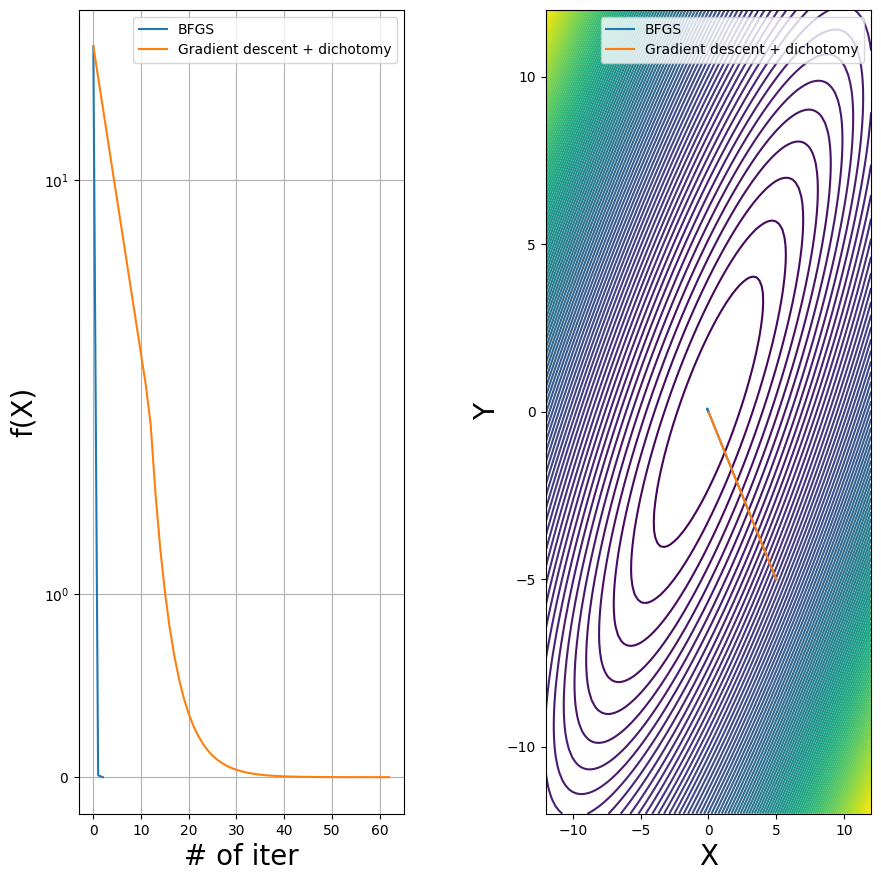

In [12]:
from funcs import f_matias
from bfgs import bfgs

import descent

visualization.visualize_multiple_descent_2args(
    {
        "BFGS": bfgs(
            f_matias, descent.numeric_gradient, x_0=np.array((5.0, -5.0)), epochs=1000
        ),
        "Gradient descent + dichotomy": descent.grad_descent_with_dichotomy(
            f_matias,
            descent.numeric_gradient,
            x0=np.array((5.0, -5.0)),
            lr=0.1,
            tol=0.01,
            epoch=1000,
        ),
    },
    f_matias,
)

### Линейная регрессия

8
Всего точек: 100
Минимум в  [1.88 5.58]
Значение функции в точке минимума:  2289.994959846009


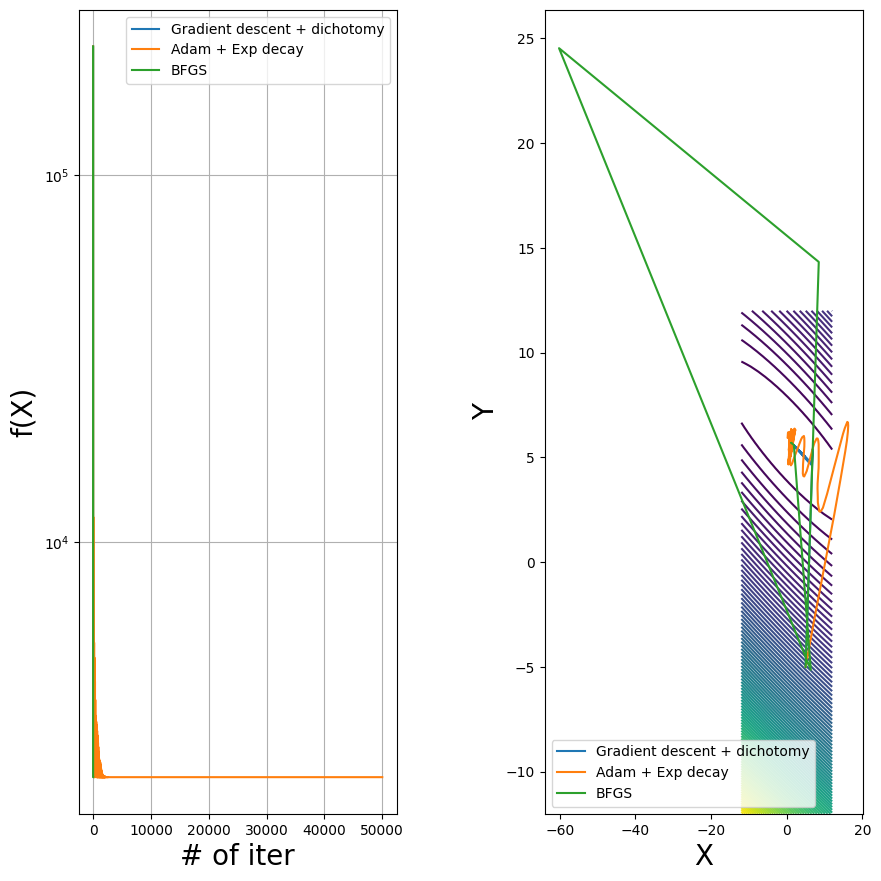

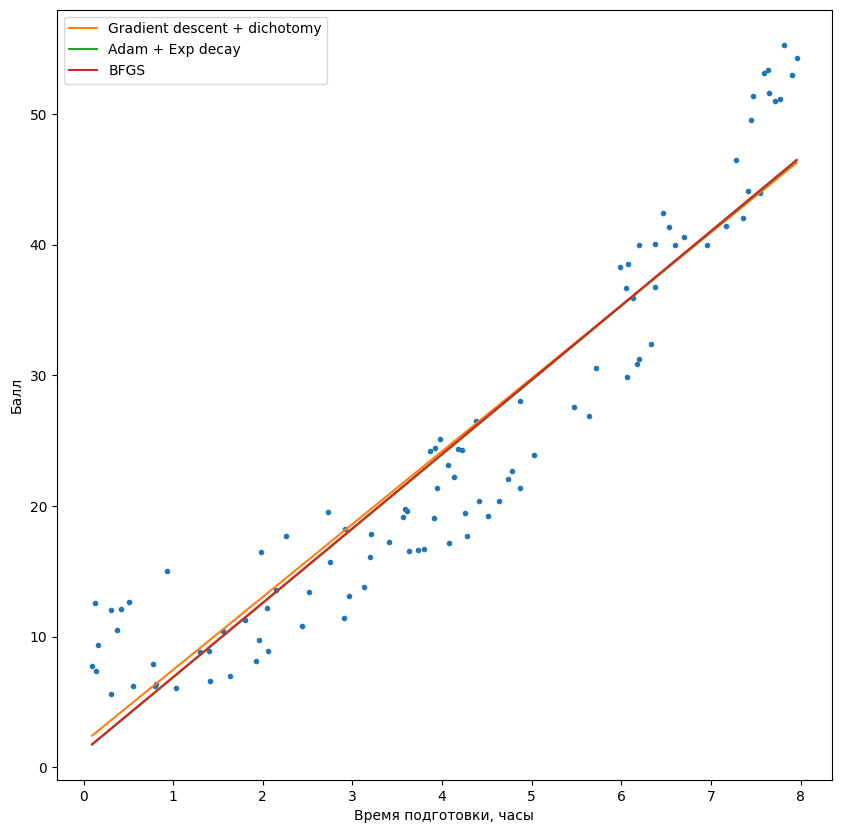

In [13]:
from funcs import squared

f, f_chunk = dataset.get_linear_loss_func(*data)
visualization.linear_multiple_demo_2args(
    {
        "Gradient descent + dichotomy": descent.grad_descent_with_dichotomy(
            f,
            descent.numeric_gradient,
            x0=np.array((5.0, -5.0)),
            lr=0.1,
            tol=0.01,
            epoch=100,
        ),
        "Adam + Exp decay": descent.adam_minibatch_descent(
            f=squared(f_chunk),
            df=descent.numeric_gradient,
            x0=np.array([5.0, -5.0]),
            decay=descent.exp_decay(1.0, 0.1),
            n_epochs=1000,
            batch_size=2,
            tol=0.09,
        ),
        "BFGS": bfgs(
            f, descent.numeric_gradient, x_0=np.array((5.0, -5.0)), epochs=100
        ),
    },
    f,
    *data
)

### Нелинейная регрессия

In [14]:
f, f_chunk = dataset.get_nonlinear_loss_func(*data_weather)
points = bfgs(
    f,
    descent.numeric_gradient,
    x_0=np.array([17.0, 0.0, 0.0, 0.0, 8.5, 0.0000002, 2.9]),
    epochs=10,
)
print(points)
visualization.visualize_descent(points, f)
visualization.visualize_regression(
    points[-1], *data_weather, "Время", "Температура", regression.sine_model
)

/Users/snitron/PycharmProjects/meth_opt_lab3/regression.py:69: RuntimeWarning: overflow encountered in scalar power
  return lambda W: sum([i(W) ** 2 for i in funcs])


KeyboardInterrupt: 

### Более простая нелинейная функция (Rosenbrock)

Глобальный минимум: [1.0, 1.0]
415
Конечная точка метода Gradient descent + dichotomy: [0.92 0.85]
Конечная точка метода Adam + Exp decay: [-1.8517320263859876 -0.7534888621131554]
Конечная точка метода Powell Dog Leg: [-0.42 -6.87]
Конечная точка метода BFGS: [1. 1.]


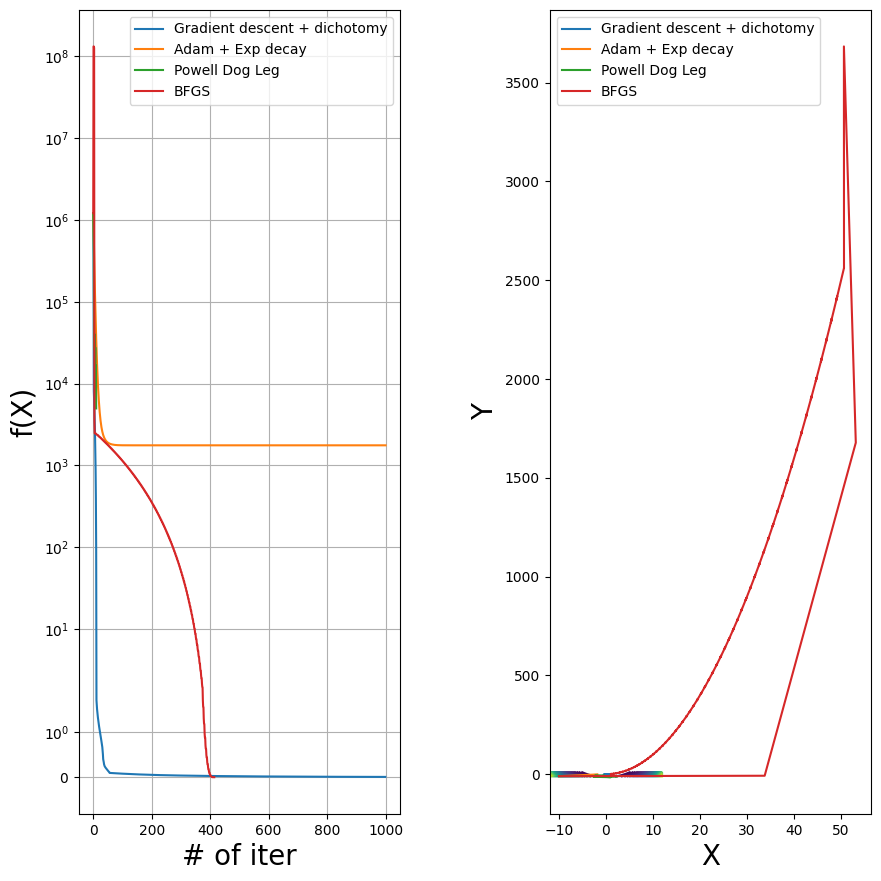

In [17]:
from funcs import f_rosenbrock
from funcs import f_rosenbrock_chunk
from funcs import squared

from bfgs import bfgs, l_bfgs

import descent

print("Глобальный минимум: [1.0, 1.0]")
visualization.visualize_multiple_descent_2args(
    {
        "Gradient descent + dichotomy": descent.grad_descent_with_dichotomy(
            f_rosenbrock,
            descent.numeric_gradient,
            x0=np.array((-10.0, -10.0)),
            lr=0.1,
            tol=0.01,
            epoch=1000,
        ),
        "Adam + Exp decay": descent.adam_minibatch_descent(
            f=squared(f_rosenbrock_chunk()),
            df=descent.numeric_gradient,
            x0=np.array([-10.0, -10.0]),
            decay=descent.exp_decay(1.0, 0.1),
            n_epochs=1000,
            batch_size=2,
            tol=0.01,
        ),

        "Powell Dog Leg": descent.powell_dog_leg(
            x0=np.array([-10.0, -10.0]),
            rsl=f_rosenbrock_chunk(),
            grad=descent.numeric_gradient,
        ),
        "BFGS": bfgs(
            f_rosenbrock,
            descent.numeric_gradient,
            x_0=np.array((0.0, 0.5)),
            epochs=1000
        )
    },
    f_rosenbrock,
    print_points=True,
)

### Выводы


Метод BFGS (Broyden-Fletcher-Goldfarb-Shanno) является одним из наиболее эффективных методов квазиньютоновской оптимизации, особенно когда речь идет о выпуклых функциях. Как показали результаты этой работы, метод BFGS отлично справляется с оптимизацией квадратичных и линейных функций, которые представляют собой типичные примеры выпуклых функций.

Однако, когда речь заходит о нелинейной регрессии с синусоидальной моделью, метод BFGS столкнулся с трудностями. Это может быть связано с несколькими факторами:

1. Локальная природа оптимизации: BFGS, как и другие методы градиентного спуска, стремится найти оптимальное решение путем итеративного улучшения текущего решения. Однако, если начальное приближение находится далеко от оптимума, или функция имеет много локальных минимумов, BFGS может застрять в локальном минимуме, а не найти глобальный.

2. Сложность модели: Синусоидальные модели часто бывают сложными для оптимизации из-за их осциллирующего характера и периодичности.

В целом, BFGS - мощный инструмент для оптимизации, но, как и любой инструмент, он имеет свои ограничения.

# Бонусное задание

## Задание 1. Реализация метода L-BFGS

Название говорит само за себя: L(imited Memory)-BFGS. Это модификация предыдущего метода оптимизации, позволяющая использовать линейное количество памяти для хранения состояния и проводить итерацию за линейное время $O(md)$, где $m$ --- количество сохранённых в памяти итераций, а $d$ --- размерность векторов.

Вместо того, чтобы хранить весь обратный гессиан $H_k$ в памяти, нам достаточно хранить лишь пары $(s_k, y_k)_{k - m \ldots k}$, после чего мы сможем приближенно вычислить $H_k \approx \gamma I$, где $\gamma = \frac{s_{k - 1}^{T}y_{k - 1}}{y_{k - 1}^{T}y_{k - 1}}$

Таким образом, восстанавливаем направление по алгоритму ниже за $O(md)$:

![image](static/lbfgs.svg)

Производительности и точность сильно зависят от выбора константы $m$.


### Квадратичная функция

3


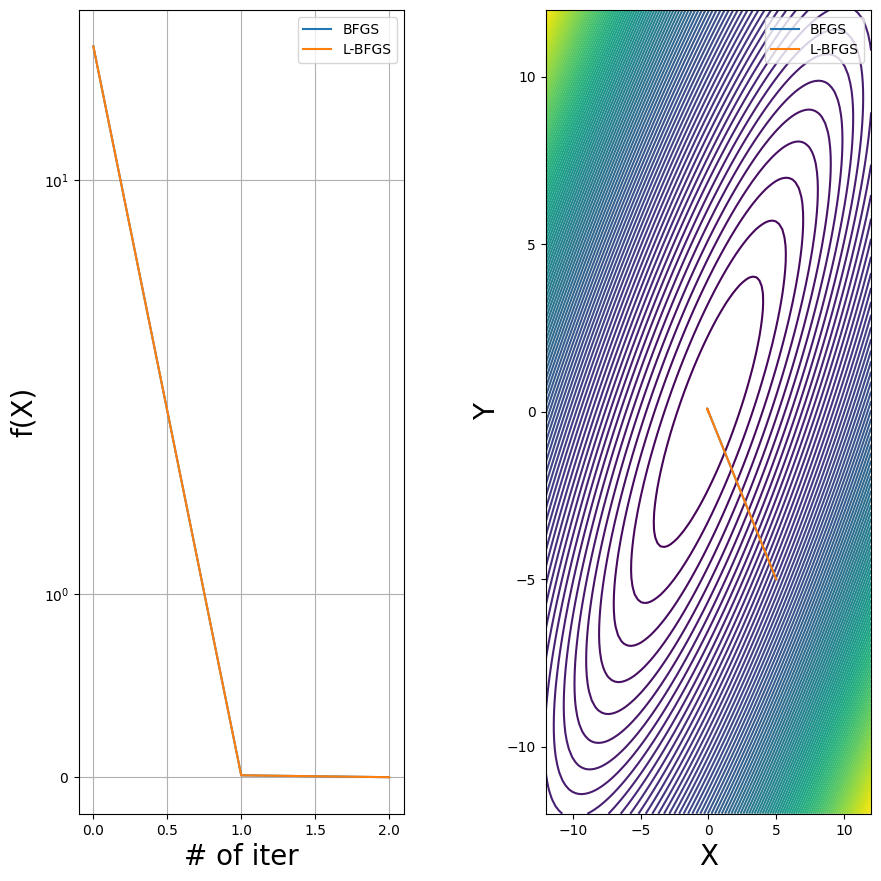

In [24]:
from funcs import f_matias
from bfgs import l_bfgs

import descent

visualization.visualize_multiple_descent_2args(
    {
        "BFGS": bfgs(
            f_matias, descent.numeric_gradient, x_0=np.array((5.0, -5.0)), epochs=1000
        ),
        "L-BFGS": l_bfgs(
            f_matias, descent.numeric_gradient, x_0=np.array((5.0, -5.0)), epochs=1000
        ),
    },
    f_matias,
)

### Линейная регрессия

In [ ]:
f, f_chunk = dataset.get_linear_loss_func(*data)
visualization.linear_multiple_demo_2args(
    {
        "BFGS": bfgs(
            f, descent.numeric_gradient, x_0=np.array((5.0, -5.0)), epochs=100
        ),
        "L-BFGS": l_bfgs(
            f, descent.numeric_gradient, x_0=np.array((5.0, -5.0)), epochs=100
        ),
    },
    f,
    *data
)

### Нелинейная регрессия

In [ ]:
f, f_chunk = dataset.get_nonlinear_loss_func(*data_weather)
points = l_bfgs(
    f,
    descent.numeric_gradient,
    x_0=np.array([17.0, 0.0, 0.0, 0.0, 8.5, 0.0000002, 2.9]),
    epochs=10,
)
print(points)
visualization.visualize_descent(points, f)
visualization.visualize_regression(
    points[-1], *data_weather, "Время", "Температура", regression.sine_model
)

### Более простая нелинейная функция (Rosenbrock)

Глобальный минимум: [1.0, 1.0]
Конечная точка метода L-BFGS m=2: [1. 1.]
Конечная точка метода L-BFGS m=3: [1. 1.]
Конечная точка метода L-BFGS m=4: [1. 1.]
Конечная точка метода L-BFGS m=5: [1. 1.]
Конечная точка метода L-BFGS m=10: [1. 1.]
Конечная точка метода L-BFGS m=50: [1. 1.]


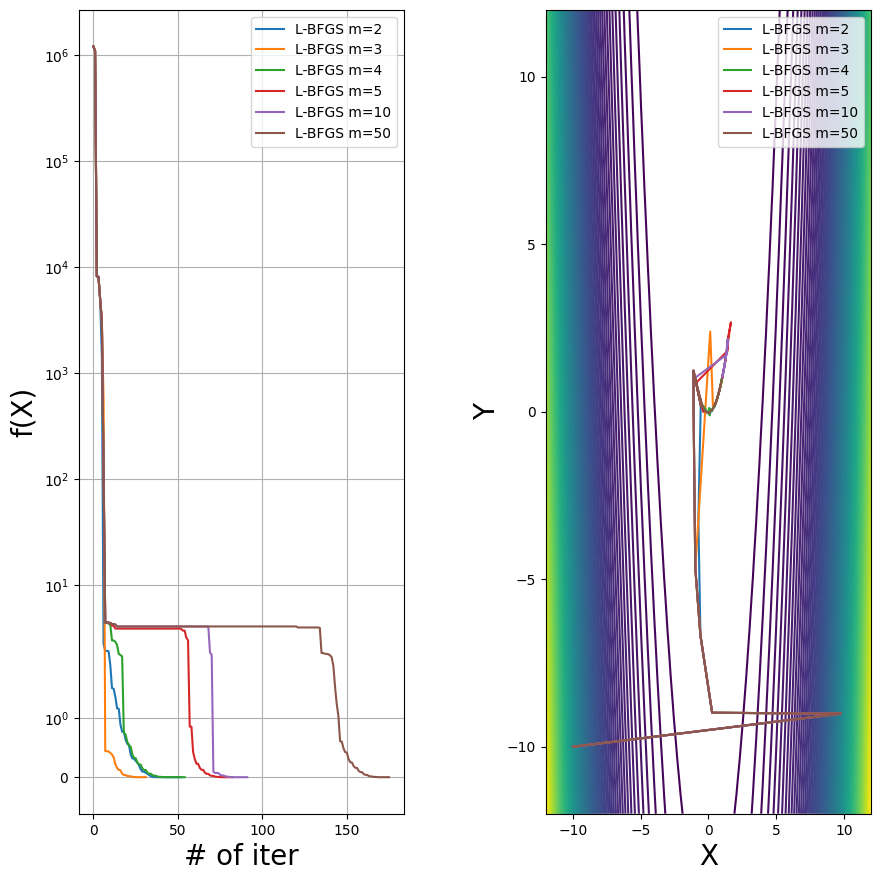

In [22]:
from funcs import f_rosenbrock
from funcs import f_rosenbrock_chunk
from funcs import squared

from bfgs import bfgs

import descent

print("Глобальный минимум: [1.0, 1.0]")
visualization.visualize_multiple_descent_2args(
    {
        "BFGS": bfgs(
            f_rosenbrock,
            descent.numeric_gradient,
            x_0=np.array((-10.0, -10.0)),
            epochs=1000,
        ),
        "L-BFGS": l_bfgs(
            f_rosenbrock,
            descent.numeric_gradient,
            x_0=np.array((-10.0, -10.0)),
            epochs=1000,
        ),
        # TODO: добавить версии с l_bfgs с разными параметрами M
    },
    f_rosenbrock,
    print_points=True,
)

### Выводы


Метод L-BFGS (Limited-memory Broyden-Fletcher-Goldfarb-Shanno) — это вариация метода BFGS, которая использует значительно меньше памяти. Этот метод был разработан для решения задач оптимизации большого размера, где полный гессиан или его приближение в методе BFGS может быть слишком дорогим для хранения в памяти.

Преимущества L-BFGS:

1. Эффективность памяти: L-BFGS использует значительно меньше памяти по сравнению с BFGS, что делает его идеальным для больших задач оптимизации.

2. Скорость: L-BFGS обычно сходится быстрее, чем BFGS на больших проблемах, потому что он требует меньше памяти и вычислений для каждого шага оптимизации.

Недостатки L-BFGS:

1. Сложность настройки: L-BFGS имеет дополнительный гиперпараметр — количество хранимых векторов ($m$), которые используются для приближения обратной матрицы Гессе. Настройка этого параметра может быть сложной.

2. Неточность: Поскольку L-BFGS использует только ограниченную информацию из прошлых итераций, он может быть менее точным, чем полный BFGS, особенно на небольших задачах оптимизации.

В целом, L-BFGS работает лучше, когда решается задача с большим количеством параметров или когда доступ к памяти ограничен. Он может быть менее эффективным на небольших задачах или когда точность является главным приоритетом.

# Заключение



## Вывод

В ходе этой лабораторной работы были изучены и реализованы методы высокого порядка для решения задач оптимизации, включая нелинейную регрессию и минимизацию функций. Были реализованы и исследованы методы Gauss-Newton, Powell Dog Leg, BFGS и L-BFGS.

Методы Gauss-Newton и Powell Dog Leg показали свою эффективность при решении задач нелинейной регрессии, особенно когда функция потерь хорошо приближается квадратичной функцией.

Метод BFGS эффективно справлялся с оптимизацией квадратичных и линейных функций, но столкнулся с трудностями при оптимизации нелинейной регрессии с синусоидальной моделью. Это подчеркивает важность выбора правильного метода для конкретного типа функции и данных.

L-BFGS, с другой стороны, оказался эффективным вариантом для решения задач оптимизации большого размера, где полная матрица Гессе или ее приближение может быть слишком большой для хранения в памяти.

В целом, все исследованные методы представляют собой мощные инструменты для оптимизации, но каждый из них имеет свои преимущества и ограничения. Выбор подходящего метода зависит от конкретной задачи, типа функции и данных. Эта работа подчеркнула важность понимания подходящих сценариев применения для каждого из этих методов, а также их потенциальных ограничений.